## MNIST DCGAN:
GAN training of a CNN generator and discriminator on MNIST data. Frechet Distance scores from a basic classifier used as a metric.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.autograd import grad
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
from scipy.linalg import sqrtm

In [2]:
ROOT = Path.cwd() / "data" / "mnist"

In [3]:
X_train = np.load(ROOT / "X_train.npy")
X_test = np.load(ROOT / "X_test.npy")
xmean = 0.5
xstd = 0.5
X_train = (X_train - xmean) / xstd
X_test = (X_test - xmean) / xstd
y_train = np.load(ROOT / "y_train.npy")
y_test = np.load(ROOT / "y_test.npy")

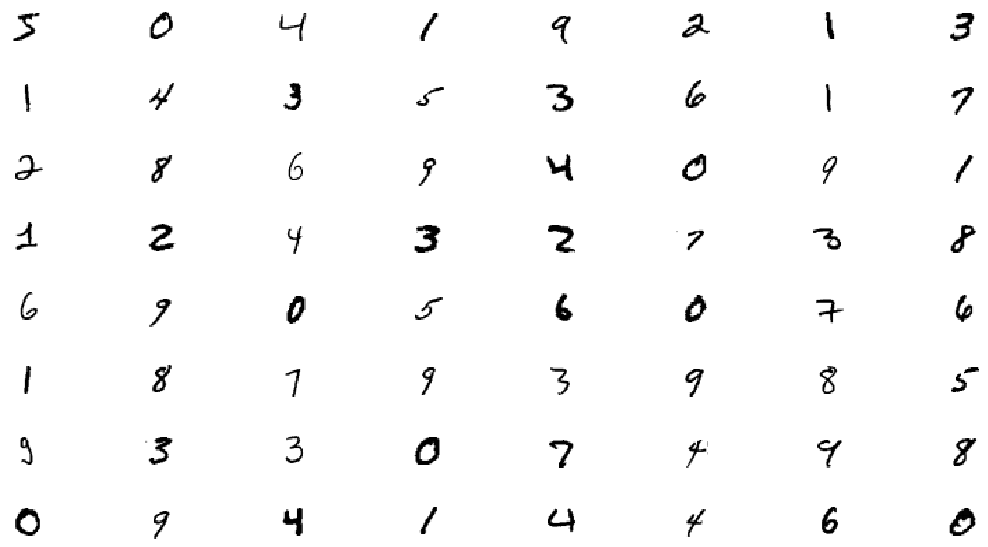

In [47]:
fig, axs = plt.subplots(8, 8, figsize=(15, 8))
fig.tight_layout()
i = 0
for row in axs:
    for col in row:
        col.imshow(X_train[i],  cmap="gray_r")
        col.axis('off')
        i += 1
plt.show()

In [5]:
X = torch.from_numpy(X_train).view(-1, 1, 28, 28)
y = torch.from_numpy(y_train)
Xt = torch.from_numpy(X_test).view(-1, 1, 28, 28)
yt = torch.from_numpy(y_train)

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(16, 10)
        
    def forward(self, x):
        return self.fc(self.convs(x))

In [7]:
class FD:
    """Adapted from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/."""
    def __init__(self, classifier, X):
        self.classifier = classifier
        self.m, self.sigma = self.get_stats(X)
        
    def get_stats(self, X):
        act = self.classifier.convs(X)
        act = act.detach().numpy()
        m = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return m, sigma
        
    def __call__(self, X):
        m, sigma = self.get_stats(X)
        ssdiff = ((self.m - m)**2.0).sum()
        covmean = sqrtm(self.sigma.dot(sigma))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fd = ssdiff + np.trace(self.sigma + sigma - 2.0 * covmean)
        return fd 

In [8]:
cls = Classifier()
opt = optim.Adam(cls.parameters(), lr=0.001, weight_decay=0.00001)
crit = nn.CrossEntropyLoss()

In [9]:
cls_trainset = DataLoader(TensorDataset(X, y), batch_size=64, shuffle=True)
cls_testset = DataLoader(TensorDataset(Xt, yt), batch_size=64, shuffle=True)

In [10]:
def cls_acc(preds, labels):
    size = len(preds)
    p = torch.argmax(preds, axis=1)
    correct = (p == labels).sum().item()
    return correct / size

In [11]:
def train_cls_fd(cls, cls_trainset, cls_testset):
    for epoch in range(10):
        accs = []
        for x, y in cls_trainset:
            preds = cls(x)
            loss = crit(preds, y)
            acc = cls_acc(preds, y)
            accs.append(acc)
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            accs = []
            for x, y in cls_testset:
                preds = cls(x)
                acc = cls_acc(preds, y)
                accs.append(acc)
        print(f"Epoch: {epoch + 1}, Acc: {np.mean(accs):.5f}")

In [12]:
train_cls_fd(cls, cls_trainset, cls_testset)

Epoch: 1, Acc: 0.90608
Epoch: 2, Acc: 0.93673
Epoch: 3, Acc: 0.94763
Epoch: 4, Acc: 0.95293
Epoch: 5, Acc: 0.95719
Epoch: 6, Acc: 0.96044
Epoch: 7, Acc: 0.96449
Epoch: 8, Acc: 0.96460
Epoch: 9, Acc: 0.96730
Epoch: 10, Acc: 0.96337


In [13]:
for p in cls.parameters():
    p.requires_grad = False
fd = FD(cls, X)
fd(Xt), fd(torch.randn(1, 1, 28, 28))

(-5.719869022868806e-13, 836.6857705200694)

In [14]:
class BasicDiscriminator(nn.Module):
    def __init__(self, size=4, n_blocks=3):
        super().__init__()
        layers = []
        c_in = 1
        c_out = size
        for layer in range(n_blocks):
            layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, stride=2))
            if layer != 0:
                layers.append(nn.BatchNorm2d(c_out))
            layers.append(nn.LeakyReLU(0.2))
            c_in = c_out
            c_out = c_out * 2
        self.convs = nn.Sequential(*layers)
        with torch.no_grad():
            bs, c, h, w = self.convs(torch.randn(16, 1, 28, 28)).shape
        f_size = c * h * w
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(f_size, 1), nn.Sigmoid())
        
    def forward(self, x):
        x = self.convs(x)
        return self.head(x)

In [15]:
class BasicGenerator(nn.Module):
    def __init__(self, latent_size=100, size=16):
        super().__init__()
        self.latent_size = latent_size
        self.size = size
        n_start = size * 4 * 4
        self.bc = nn.BatchNorm1d(latent_size)
        self.fc = nn.Linear(latent_size, n_start)
        self.relu = nn.ReLU(True)
        self.main = nn.Sequential(
            # 4 x 4 -> 7 x 7
            nn.ConvTranspose2d(size, size // 2, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(size // 2),
            nn.ReLU(True),
            # 7 x 7 -> 14 x 14
            nn.ConvTranspose2d(size // 2, size // 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(size // 4),
            nn.ReLU(True),
            # 14 x 14 -> 28 x 28
            nn.ConvTranspose2d(size // 4, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, batch_size=64):
        z = torch.randn(batch_size, self.latent_size)
        z = self.relu(self.fc((z)))
        z = z.view(-1, self.size, 4, 4)
        return self.main(z)

In [16]:
def set_requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [17]:
class DLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss(reduction="none")
        
    def forward(self, true_preds, fake_preds):
        t_loss = self.loss(true_preds, torch.ones(len(true_preds), 1))
        f_loss = self.loss(fake_preds, torch.zeros(len(fake_preds), 1))
        return torch.cat((t_loss, f_loss), axis=0).mean()

In [18]:
class R1Pen(nn.Module):
    """Adpated from https://github.com/Yangyangii/GAN-Tutorial/blob/master/CelebA/R1GAN.ipynb"""
    def __init__(self, gamma=10):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, true_imgs, true_preds):
        grad_true = grad(outputs=true_preds.sum(), inputs=true_imgs, create_graph=True)[0]
        grad_penalty = (grad_true.view(grad_true.size(0), -1).norm(2, dim=1) ** 2).mean()
        return 0.5 * self.gamma * grad_penalty

In [19]:
class GLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss()
        
    def forward(self, fake_preds):
        return self.loss(fake_preds, torch.ones(len(fake_preds), 1))

In [20]:
def accuracy(true_preds, fake_preds):
    t_acc = (true_preds >= 0.5).sum()
    f_acc = (fake_preds < 0.5).sum()
    return (t_acc + f_acc) / ( float(len(true_preds) + len(fake_preds)))

In [21]:
def train_epoch(loader, gen, discrim, g_crit, d_crit, g_opt, d_opt, fd, r1=None):
    d_losses = []
    d_accs = []
    g_losses = []
    f_preds = []
    t_preds = []
    fd_scores = []
    for true_imgs in loader:
        gen.eval()
        discrim.train()
        d_loss, d_acc, fp, tp = train_discrim(true_imgs, gen, discrim, d_crit, d_opt, r1)
        gen.train()
        #discrim.eval() bn states wrong. don't do this!
        g_loss, fd_score = train_gen(gen, discrim, g_crit, g_opt, fd)
        d_losses.append(d_loss)
        d_accs.append(d_acc)
        f_preds.append(fp)
        t_preds.append(tp)
        g_losses.append(g_loss)
        fd_scores.append(fd_score)
    return d_losses, d_accs, g_losses, fd_scores, f_preds, t_preds

In [22]:
def train_discrim(true_imgs, gen, discrim, d_crit, d_opt, r1=None):
    set_requires_grad(gen, False)
    set_requires_grad(discrim, True)
    fake_imgs = gen()
    if r1:
        true_imgs.requires_grad = True
    true_preds = discrim(true_imgs)
    grad_penalty = 0
    if r1:
        grad_penalty = r1(true_imgs, true_preds)
    fake_preds = discrim(fake_imgs)
    loss = d_crit(true_preds, fake_preds) + grad_penalty
    acc = accuracy(true_preds, fake_preds)
    d_opt.zero_grad()
    loss.backward()
    d_opt.step()
    return loss.item(), acc.item(), fake_preds.mean().item(), true_preds.mean().item()

In [23]:
def train_gen(gen, discrim, g_crit, g_opt, fd):
    set_requires_grad(gen, True)
    set_requires_grad(discrim, False)
    fake_imgs = gen()
    fake_preds = discrim(fake_imgs)
    loss = g_crit(fake_preds)
    g_opt.zero_grad()
    loss.backward()
    g_opt.step()
    fd_score = fd(fake_imgs)
    return loss.item(), fd_score

In [24]:
def moving_average(x, w=200):
    return np.convolve(x, np.ones(w), 'valid') / w

In [37]:
batch_size = 64
datasize = 60000
train_set = DataLoader(X[:datasize], batch_size=batch_size, shuffle=True) 

In [38]:
g_crit = GLoss()
d_crit = DLoss()
r1 = R1Pen()

In [40]:
latent_size = 64
size = 64
d_size = size // 4
gen = BasicGenerator(latent_size, size)
discrim = BasicDiscriminator(d_size)
g_opt = optim.Adam(gen.parameters(), lr=0.002, betas=(0.5, 0.999))
d_opt = optim.Adam(discrim.parameters(), lr=0.002, betas=(0.5, 0.999))
g_sched  = optim.lr_scheduler.ReduceLROnPlateau(g_opt, mode='min', factor=0.1, patience=2, eps=1e-6, verbose=True)
d_sched  = optim.lr_scheduler.ReduceLROnPlateau(d_opt, mode='min', factor=0.1, patience=2, eps=1e-6, verbose=True)

In [41]:
fds = []
dlosses = []
glosses = []
fps = []
tps = []
print("Epoch   DLoss   Dacc  Gloss    Gfd     FP     TP")
for i in range(40):
    dloss, dacc, gloss, fd_score, fp, tp = train_epoch(train_set, gen, discrim, g_crit, d_crit, g_opt, d_opt, fd, r1)
    print(f"{i+1}:     {np.mean(dloss):.4f}  {np.mean(dacc):.3f}  {np.mean(gloss):.4f}  {np.mean(fd_score):.2f}  {np.mean(fp):.3f}  {np.mean(tp):.3f}")
    fsched = torch.mean(torch.tensor(fd_score))
    g_sched.step(fsched)
    d_sched.step(fsched)
    fds += fd_score
    dlosses += dloss
    glosses += gloss
    fps += fp
    tps += tp

Epoch   DLoss   Dacc  Gloss    Gfd     FP     TP
1:     0.5917  0.807  1.0521  131.75  0.426  0.637
2:     0.6530  0.731  0.8062  26.41  0.462  0.551
3:     0.6651  0.698  0.7735  23.50  0.472  0.535
4:     0.6718  0.669  0.7561  22.91  0.478  0.526
5:     0.6765  0.650  0.7432  22.08  0.482  0.520
6:     0.6796  0.635  0.7361  22.62  0.485  0.516
7:     0.6809  0.633  0.7304  22.17  0.486  0.515
8:     0.6824  0.625  0.7271  22.36  0.488  0.513
Epoch     8: reducing learning rate of group 0 to 2.0000e-04.
Epoch     8: reducing learning rate of group 0 to 2.0000e-04.
9:     0.6791  0.700  0.7221  18.94  0.486  0.512
10:     0.6793  0.704  0.7199  18.16  0.488  0.513
11:     0.6797  0.704  0.7189  18.09  0.488  0.513
12:     0.6805  0.697  0.7189  18.06  0.488  0.513
13:     0.6810  0.695  0.7184  17.93  0.488  0.513
14:     0.6813  0.690  0.7183  18.47  0.488  0.512
15:     0.6817  0.686  0.7179  18.00  0.489  0.512
16:     0.6820  0.684  0.7175  17.75  0.489  0.512
17:     0.6820  0.6

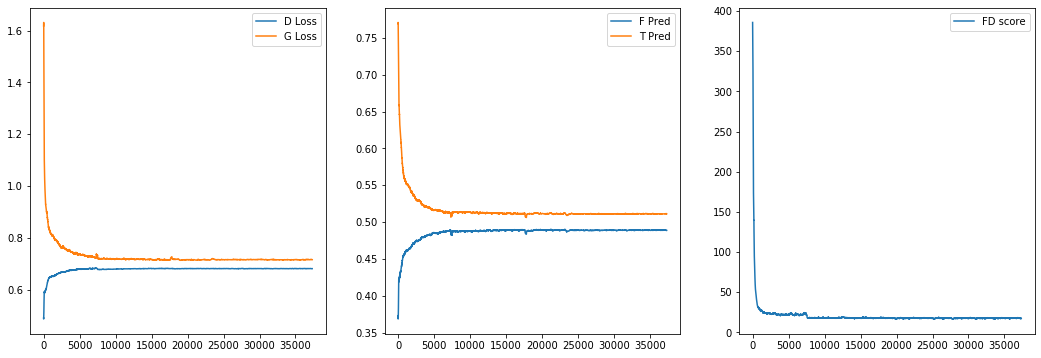

In [42]:
fds = moving_average(fds, w=200)
dlosses = moving_average(dlosses, w=200)
glosses = moving_average(glosses, w=200)
fps = moving_average(fps, w=200)
tps = moving_average(tps, w=200)

fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].plot(dlosses, label="D Loss")
ax[0].plot(glosses, label="G Loss")
ax[0].legend()
ax[1].plot(fps, label="F Pred")
ax[1].plot(tps, label="T Pred")
ax[1].legend()
ax[2].plot(fds, label="FD score")
ax[2].legend()
plt.show()

In [45]:
def show_examples(gen, dl):
    x_b = next(iter(dl))
    gen.eval()
    with torch.no_grad():
        fake_imgs = gen()[:64]
    fig, axs = plt.subplots(8, 8, figsize=(15, 8))
    fig.tight_layout()
    i = 0
    for row in axs:
        for col in row:
            col.imshow(fake_imgs[i,0].detach().numpy(),  cmap="gray_r")
            col.axis('off')
            i += 1
    plt.show()

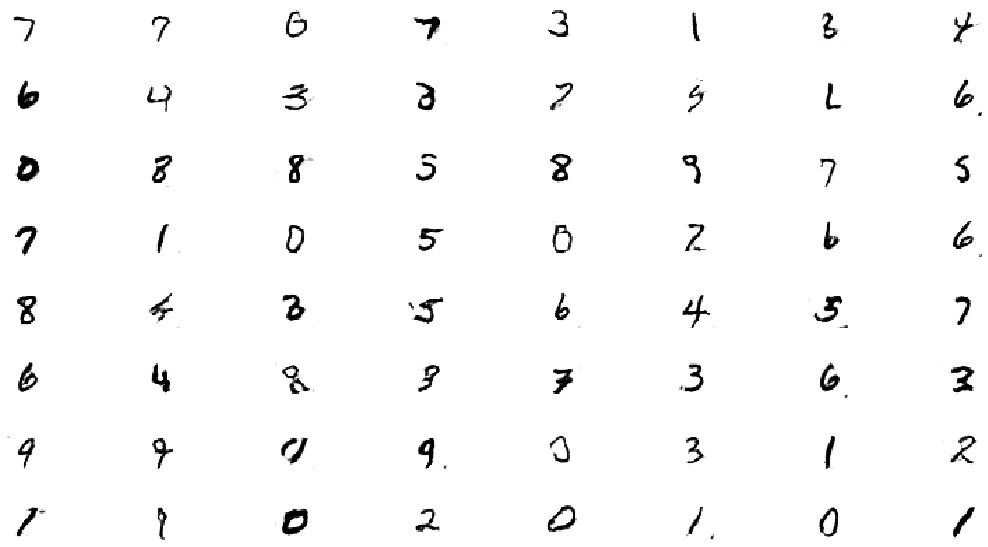

In [46]:
show_examples(gen, train_set)